In [16]:
import numpy as np
import io_subs
import importlib
importlib.reload(io_subs)
import sim_tb
importlib.reload(sim_tb)
import pyresample
from pyresample import kd_tree, geometry
from pyresample.kd_tree import resample_nearest, resample_gauss, resample_custom
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyresample import image, geometry
import lkTables

lookupT=lkTables.scattTables()

bwy=[32.1,32.1,18.1,18.1,16.,15.6,15.6,7.2,7.2]
bwx=[19.4,19.4,10.9,10.9,9.7,9.4,9.4,4.4,4.4]
bwx=np.array(bwx)
bwy=np.array(bwy)

def antenna_pattern(bwx, bwy):
    bpatt=np.zeros((9,7),float)
    for i in range(9):
        for j in range(7):
            ddx=(i-4)*5
            ddy=(j-3)*5
            y2=(((ddx/bwx)**2+(ddy/bwy)**2)*4*np.log(2.))
            bpatt[i,j]=np.exp(-y2)
    return bpatt

ant_pattL=[]
for i in range(9):
    ant_patt=antenna_pattern(bwx[i], bwy[i])
    ant_pattL.append(ant_patt/ant_patt.sum())


In [17]:
from numba import jit
@jit(nopython=True)
def jit_conv(a, k):
    m, n = a.shape
    m1, n1 = k.shape
    c= np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            c[i, j] = 0
            for i1 in range(-4,5):
                for j1 in range(-3,4):
                    i0=max(0, min(m-1, i+i1))
                    j0=max(0, min(n-1, j+j1))
                    c[i, j] += a[i0,j0]*k[i1+4, j1+3]
    return c

In [18]:



import glob

tbFiles=glob.glob('/Volumes/T7 Shield/SUBSETS/output/CMB*.nc')
tbFiles=sorted(tbFiles)
print(len(tbFiles))

histLand2=np.zeros((200,200,13),int)
import netCDF4 as nc
tbsimL=[]
tbobsL=[]
pTypeL=[]
sfcEmissL=[]
skTempL=[]
wvpL=[]
iwpL=[]
rwpL=[]
sfcBinL=[]
tb_convL=[]
stormTopL=[]
oe_wvpL=[]
oe_lwpL=[]
zeroDegL=[]
sfcPrecipL=[]
for i,tbFile in enumerate(tbFiles[0:120][::2]):
    if i%10==0:
        print(i,tbFile)
    with nc.Dataset(tbFile) as ds:
        tb=ds['tb'][:]
        tb_convs_L=[]
        for ifreq in range(9):
            tb_conv=jit_conv(tb[:,:,ifreq].data,ant_pattL[ifreq])
            tb_convs_L.append(tb_conv[:,:,np.newaxis])
        tb_conv=np.concatenate(tb_convs_L,axis=2)
        tb_resampled=ds['tb_resampled'][:]
        pType=ds['pType'][:]
        sfcType=ds['surfaceType'][:]
        wvp=ds['wvp'][:]
        iwp=ds['iwp'][:]
        rwp=ds['rwp'][:]
        lwp=ds['oe_lwp'][:]
        oe_wvp=ds['oe_wvp'][:]
        stormTop=ds['stormTop'][:]
        sfcEmiss=ds['sfcEmiss'][:]
        sfcBin=ds['sfcBin'][:]
        skTemp=ds['skTemp'][:]
        zeroDeg=ds['zeroDeg'][:]
        sfcPrecip=ds['sfcPrecip'][:]
        #stop
        a=np.nonzero(sfcType>0)
        b=np.nonzero(pType[a]>=0)
        stormTop[stormTop<-9]=-9
        #print(tb.shape)
        #print(tb_resampled.shape)
        #print(sfcType.shape)'
        nt=tb.shape[0]
        nr=tb.shape[1]
        dnx=4
        dny=3
        for i,j in zip(a[0][b],a[1][b]):
            if i>6 and i<nt-6 and j>15 and j<nr-15:
                if skTemp[i,j]<273.15:
                    continue
                tbobs_mean=tb_resampled.data[i-dnx:i+dnx+1,j-dny:j+dny+1,:].mean()
                if tbobs_mean!=tbobs_mean:
                    continue
                tbsimL.append(tb[i-dnx:i+dnx+1,j-dny:j+dny+1,:])
                tb_convL.append(tb_conv[i-dnx:i+dnx+1,j-dny:j+dny+1,:])
                tbobsL.append(tb_resampled[i-dnx:i+dnx+1,j-dny:j+dny+1,:])
               #pTypeL.append(pType[i-6:i+7,j-6:j+7])
               #wvpL.append(wvp[i-6:i+7,j-6:j+7])
               #iwpL.append(iwp[i-6:i+7,j-6:j+7])
               #rwpL.append(rwp[i-6:i+7,j-6:j+7])
                sfcBinL.append(sfcBin[i-dnx:i+dnx+1,j-dny:j+dny+1])
                oe_wvpL.append(oe_wvp[i-dnx:i+dnx+1,j-dny:j+dny+1])
                oe_lwpL.append(lwp[i-dnx:i+dnx+1,j-dny:j+dny+1])
               #sfcEmissL.append(sfcEmiss[i-6:i+7,j-6:j+7,:])
               #skTempL.append(skTemp[i-6:i+7,j-6:j+7])  
                pTypeL.append(pType[i,j])
                stormTopL.append(stormTop[i,j])
                wvpL.append(wvp[i,j])
                iwpL.append(iwp[i,j])
                rwpL.append(rwp[i,j])
                skTempL.append(skTemp[i-dnx:i+dnx+1,j-dny:j+dny+1])
                sfcEmissL.append(sfcEmiss[i,j,:])   
                sfcPrecipL.append(sfcPrecip[i,j])
                zeroDegL.append(zeroDeg[i-dnx:i+dnx+1,j-dny:j+dny+1])         
        #tbsimL.extend(tb[a][b][:,:9])
        #tbobsL.extend(tb_resampled[a][b])
        #pTypeL.extend(pType[a][b])
        #wvpL.extend(wvp[a][b])
        #iwpL.extend(iwp[a][b])
        #rwpL.extend(rwp[a][b])
        #sfcBinL.extend(sfcBin[a][b])
        #sfcEmissL.extend(sfcEmiss[a][b][:,:9])
        #skTempL.extend(skTemp[a][b])
        continue
        for i,j in zip(a[0][b],a[1][b]):
            for ichannel in range(9):
                if tb[i,j,ichannel]>100 and tb_resampled[i,j,ichannel]>100 and tb_resampled[i,j,ichannel]<300 and tb[i,j,ichannel]<300:
                    itb1=int(tb[i,j,ichannel]-100)
                    #itb1=100
                    itb2=int(tb_resampled[i,j,ichannel]-100)
                    histLand2[itb1,itb2,ichannel]+=1

154
0 /Volumes/T7 Shield/SUBSETS/output/CMB_GMI_Tbs_CONUS_027993.nc
10 /Volumes/T7 Shield/SUBSETS/output/CMB_GMI_Tbs_CONUS_028153.nc
20 /Volumes/T7 Shield/SUBSETS/output/CMB_GMI_Tbs_CONUS_028919.nc
30 /Volumes/T7 Shield/SUBSETS/output/CMB_GMI_Tbs_CONUS_029079.nc
40 /Volumes/T7 Shield/SUBSETS/output/CMB_GMI_Tbs_CONUS_030017.nc
50 /Volumes/T7 Shield/SUBSETS/output/CMB_GMI_Tbs_CONUS_030816.nc


In [19]:
print(tb_conv.shape)
a=np.nonzero(skTemp>273.15)
for i in range(9):
    print(i, np.corrcoef(tb_conv[:,:,i][a], tb[:,:,i][a])[0,1])

(7934, 49, 9)
0 0.9968384117732895
1 0.9962472171379495
2 0.9965953562275647
3 0.9959093013969597
4 0.9948698569514122
5 0.9937559008998528
6 0.9930401113838285
7 0.99356712146219
8 0.9966531724874976


In [13]:
print(len(tbsimL))

1874740


In [20]:
import xarray as xr
#tbSim=xr.DataArray(np.array(tbsimL)[:,:,:],dims=['n','nx','ny','channel'])
tbConv=xr.DataArray(np.array(tb_convL,dtype='f4')[:,:,:],dims=['n','nx','ny','channel_s1'])
tbObs=xr.DataArray(np.array(tbobsL,dtype='f4'),dims=['n','nx','ny','channel_s1'])
#pType=xr.DataArray(np.array(pTypeL),dims=['n','nx','ny',])
#sfcEmiss=xr.DataArray(np.array(sfcEmissL),dims=['n','nx','ny','channel'])
#skTemp=xr.DataArray(np.array(skTempL),dims=['n','nx','ny'])
#wvp=xr.DataArray(np.array(wvpL),dims=['n','nx','ny'])
#iwp=xr.DataArray(np.array(iwpL),dims=['n','nx','ny'])
#rwp=xr.DataArray(np.array(rwpL),dims=['n','nx','ny'])
sfcBin=xr.DataArray(np.array(sfcBinL,dtype='i2'),dims=['n','nx','ny'])
pType=xr.DataArray(np.array(pTypeL,dtype='i2'),dims=['n'])
wvp=xr.DataArray(np.array(wvpL,dtype='f4'),dims=['n'])
iwp=xr.DataArray(np.array(iwpL,dtype='f4'),dims=['n'])
rwp=xr.DataArray(np.array(rwpL,dtype='f4'),dims=['n'])
sfcEmiss=xr.DataArray(np.array(sfcEmissL,dtype='f4'),dims=['n','channel'])
skTemp=xr.DataArray(np.array(skTempL,dtype='f4'),dims=['n','nx','ny'])
stormTop=xr.DataArray(np.array(stormTopL,dtype='f4'),dims=['n'])
oe_wvp=xr.DataArray(np.array(oe_wvpL,dtype='f4'),dims=['n','nx','ny'])
oe_lwp=xr.DataArray(np.array(oe_lwpL,dtype='f4'),dims=['n','nx','ny'])
zeroDeg=xr.DataArray(np.array(zeroDegL,dtype='f4'),dims=['n','nx','ny'])
sfcPrecip=xr.DataArray(np.array(sfcPrecipL,dtype='f4'),dims=['n'])
#ds=xr.Dataset({'tbSim':tbSim,'tbObs':tbObs,'pType':pType,'sfcEmiss':sfcEmiss,'skTemp':skTemp,'wvp':wvp,'iwp':iwp,'rwp':rwp,'sfcBin':sfcBin,'tbConv':tbConv})

ds=xr.Dataset({'tbObs':tbObs,'pType':pType,'sfcEmiss':sfcEmiss,'skTemp':skTemp,'wvp':wvp,'iwp':iwp,'rwp':rwp,'sfcBin':sfcBin,'tbConv':tbConv,'stormTop':stormTop,'oe_wvp':oe_wvp,'oe_lwp':oe_lwp,'zeroDeg':zeroDeg,'sfcPrecip':sfcPrecip})


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_45336/2699527779.py:18: UserWarning: Warning: converting a masked element to nan.
  stormTop=xr.DataArray(np.array(stormTopL,dtype='f4'),dims=['n'])


In [21]:

ds=ds.assign_attrs(description="training_data_0:2:120")
complev=6
ds.to_netcdf('/Volumes/T7 Shield/SUBSETS/output/training_dataset_land_2d_0to120step2.nc',encoding={'tbConv':{'zlib':True,'complevel':complev},'tbObs':{'zlib':True,'complevel':complev},'pType':{'zlib':True,'complevel':complev},'sfcEmiss':{'zlib':True,'complevel':complev},'skTemp':{'zlib':True,'complevel':complev},'wvp':{'zlib':True,'complevel':complev},'iwp':{'zlib':True,'complevel':complev},'rwp':{'zlib':True,'complevel':complev},'sfcBin':{'zlib':True,'complevel':complev},'stormTop':{'zlib':True,'complevel':complev},'oe_wvp':{'zlib':True,'complevel':complev},'oe_lwp':{'zlib':True,'complevel':complev},'zeroDeg':{'zlib':True,'complevel':complev},'sfcPrecip':{'zlib':True,'complevel':complev}})

In [ ]:
tbsimL=np.array(tbsimL)
tbobsL=np.array(tbobsL)
wvpL=np.array(wvpL)
#tbsimL_noR=np.array(tbsimL_noR)
#tbobsL_noR=np.array(tbobsL_noR)
print(tbsimL.shape)
print(tbobsL.shape)
# import knn regressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

knn_reg=KNeighborsRegressor(n_neighbors=20)
X_train, X_test, y_train, y_test = train_test_split(tbsimL, wvpL, test_size=0.2, random_state=42)

knn_reg.fit(X_train,y_train)
y_pred=knn_reg.predict(X_test)
print(np.corrcoef(y_pred,y_test))


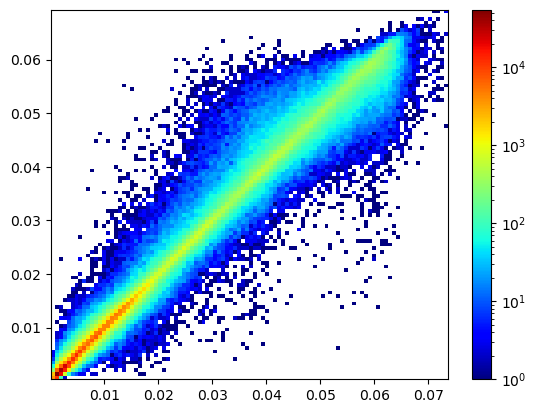

In [4]:
import matplotlib
plt.hist2d(y_test,y_pred,bins=100,cmap='jet',norm=matplotlib.colors.LogNorm())
plt.colorbar()
#print(tb[a][b].shape)
#print(tbobsL.mean(axis=0))
#print(tbsimL.mean(axis=0))
#for ichannel in range(9):
#    a=np.nonzero(tbobsL_noR[:,ichannel]==tbobsL_noR[:,ichannel])
#    b=np.nonzero(tbobsL_noR[a[0],ichannel]>100)
#    print(ichannel,np.corrcoef(tbsimL_noR[a[0][b],ichannel],tbobsL_noR[a[0][b],ichannel])[0,1])

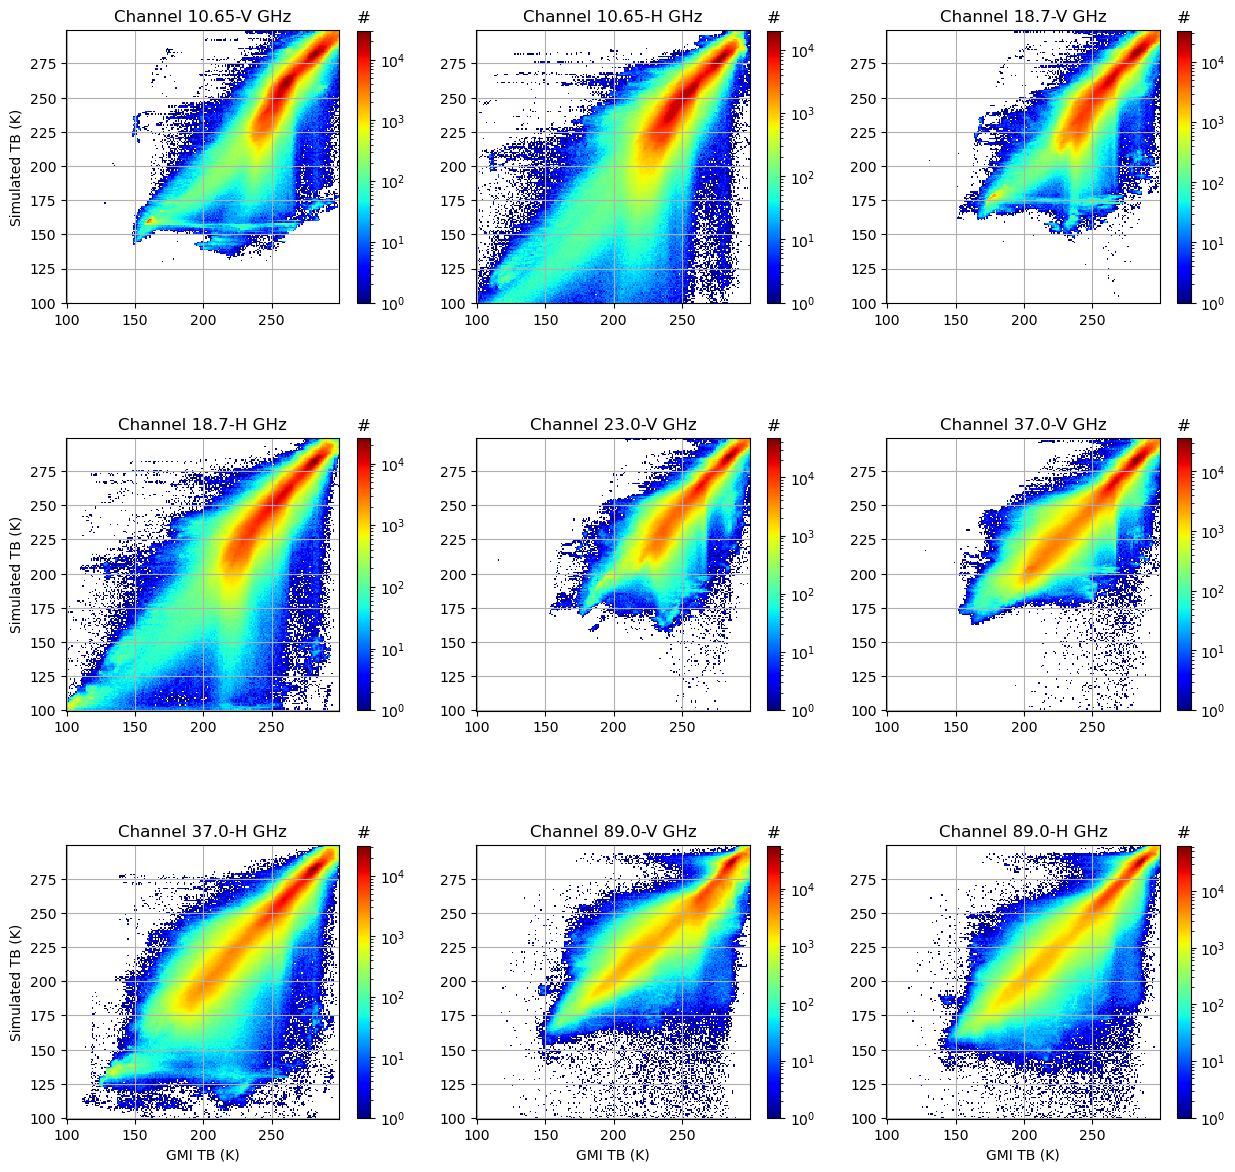

In [11]:
import matplotlib.pyplot as plt
import matplotlib
xtb=np.arange(100,300)
ytb=np.arange(100,300)
fig=plt.figure(figsize=(15,15))
freqs=['10.65-V','10.65-H','18.7-V','18.7-H','23.0-V','37.0-V','37.0-H','89.0-V','89.0-H','150.0','183.3','183.3','183.3']

for ichannel in range(9):
    ax=plt.subplot(3,3,ichannel+1)
    plt.pcolormesh(xtb[:],ytb[:],histLand2[:,:,ichannel],norm=matplotlib.colors.LogNorm(),cmap='jet')
    plt.grid()
    ax.set_aspect('equal')
    plt.title('Channel '+freqs[ichannel]+' GHz')
    cb=plt.colorbar(shrink=0.8)
    cb.ax.set_title("#")
    if ichannel==0 or ichannel==3 or ichannel==6:
        plt.ylabel('Simulated TB (K)')
    if ichannel>5:
        plt.xlabel('GMI TB (K)')

plt.savefig('histLandAllSkyGLand.png')

In [6]:
print(tbobsL.min())
xL,yL=[],[]
for i,tb1 in enumerate(tbobsL):
    if tb1.min()>100 and tb1.max()<300:
        yL.append(tb1)
        xL.append(wvpL[i])
a=np.nonzero(tbobsL[:,1]==tbobsL[:,1])
print(tbobsL[a[0],:].min())
y_pred_obs=knn_reg.predict(yL)
print(np.corrcoef(y_pred_obs,xL))

nan
nan
[[1.         0.90948058]
 [0.90948058 1.        ]]
